In [104]:
!pip install natasha
!pip install Wikipedia-API
!pip install wikipedia
!python -m spacy download ru_core_news_sm
!pip install datefinder
!pip install datasets
!pip install seqeval

2023-10-29 04:27:15.189380: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-29 04:27:15.189450: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-29 04:27:15.189491: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-29 04:27:15.199979: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-29 04:27:16.576786: W tensorflow/compiler/

In [105]:
from natasha import (Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, NewsSyntaxParser, NewsNERTagger, PER, NamesExtractor, DatesExtractor, MoneyExtractor, AddrExtractor, Doc)
import wikipediaapi
import wikipedia
import re
import datefinder
from razdel import tokenize

In [106]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)
names_extractor = NamesExtractor(morph_vocab)
data_extractor = DatesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
address_extractor = AddrExtractor(morph_vocab)

#1000 и 1 функция

активные функции

In [107]:
#ищет локацию, организацию или имя
def exctract_NER(title):
  doc=Doc(title)
  #разбивка текста на предложения
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  doc.tag_ner(ner_tagger)

  #for word in doc.tokens:
  #  word.lemmatize(morph_vocab)


  return [[x.text, replace_NER_name(x.type), x.__dict__['start']] for x in doc.spans]

In [108]:
def replace_NER_name(ner_type):
  replace_dict={'LOC':'локация','PER':'персона','ORG':'организация'}
  return replace_dict[ner_type]

In [109]:
#удаляет все ссылки из текста
def delete_links(text):
  pattern = r'<LINK>.*?<LINK>'
  match_=re.findall(pattern, text)
  #print(match_.start(),match_.end())
  text=text[:match_.start()]+'_'*(match_.end()-match_.start())+text[match_.end():]
  #cleaned_text = re.sub(pattern, '', text)
  return text

"""
def delete_links2(text):
  pattern = r'<LINK>.*?<LINK>'
  tag_text=re.sub(pattern,'<DEL LINK>' ,text)
  text_in_links = re.findall(pattern, text)
  tokineze_text_in_links=[]
  for txt in text_in_links:
    raw_toks = list(tokenize(txt))
    words = [tok.text for tok in raw_toks]
    fill_words = ' _'*len(words)
    tokineze_text_in_links.append(fill_words)

  for word_fill_tokens in tokineze_text_in_links:
    tag_text=tag_text.replace('<DEL LINK>',word_fill_tokens,1)

  return tag_text
"""

def delete_tags(text):
  cleaned_text=text.replace('<НАЗВАНИЕ:>',"_"*len('<НАЗВАНИЕ:>')).replace('<ОПИСАНИЕ:>',"_"*len('<ОПИСАНИЕ:>'))
  return cleaned_text

In [110]:
def clear_text(text):
 try: text=delete_links(text)
 except: pass
 text=delete_tags(text)

 #cleaned_text = re.sub(r'[^-а-яА-Яa-zA-Z.,/ ]', '', re.sub(r'\([^)]*\)|\{[^}]*\}|\[[^\]]*\]', '', text))
 return text

In [111]:
def exctract_date(text):
  pattern_with_dot = r'\b((\d{1,2}\.\d{1,2}\.\d{4})|(\d{1,2} (?:сентября|октября|ноября|декабря|января|февраля|марта|апреля|мая|июня|июля|августа) \d{4}))\b'
  matches = re.findall(pattern_with_dot, text)
  list_data =[]
  if not matches: return list_data
  for match in matches:
    list_data.append([match[0], 'Дата', text.find(match[0])])
  return list_data

In [112]:
import re
def find_seazon(text):
  pattern_with_dot = r'((\d+ сезон)|(сезон \d+))'
  matches = re.findall(pattern_with_dot, text)
  list_seazon = []
  if not matches:
      return list_seazon
  for match in matches:
    list_seazon.append([match[0], 'сезон', text.find(match[0])])
  return list_seazon

In [113]:
def find_epizode(text):
    pattern_with_dot = r'((серия \d+)|(\d+ серия)|(# ?\d+)|(№ ?\d+))'
    s = text.find("серия")
    text = text[s:]
    prob = " "
    prob = prob * s
    text = prob + text
    matches = re.findall(pattern_with_dot, text)
    list_epizode = []
    if not matches:
        return list_epizode
    for match in matches:
      list_epizode.append([match[0], 'серия', text.find(match[0])])
    return list_epizode

In [114]:
def extract_epizode_season(text):
  list_seazon = find_seazon(text)
  list_epizode = find_epizode(text)
  list_epizode_seria = []
  for seazon in list_seazon:
    list_epizode_seria.append(seazon)

  for epizode in list_epizode:
    list_epizode_seria.append(epizode)
  return list_epizode_seria



In [30]:
def split_title_discription(text):
  idx=text.find('<ОПИСАНИЕ:>')
  title=text[:idx]
  discription=text[idx:]
  return [title, discription]

In [31]:

sport_list=['футбол','баскетбол','теннис','волейбол','бейсбол','гандбол','хоккей','крикет','регби','американский','футбол','футзал','настольный','теннис','каратэ','бокс','бокс','борьба','пулевая','стрельба','стрельба','из','лука','гольф','велоспорт','плавание','синхронное','плавание','водное','поло','аквааэробика','дайвинг','гимнастика','акробатика','тяжелая','атлетика','парусный','спорт','виндсерфинг','кайтсерфинг','лодка','яхта','сёрфинг','скейтбординг','bmx','трюковой','спорт','танцы','балет','лыжи','альпинизм','туризм','football','basketball','tennis','volleyball','baseball','handball','hockey','cricket','rugby','american','football','futsal','table','tennis','karate','boxing','boxing','wrestling','bullet','shooting','archery','golf','cycling','swimming','synchronized','swimming','water','polo','water','aerobics','diving','gymnastics','acrobatics','weightlifting','sailing','windsurfing','kitesurfing','boat','yacht','surfing','skateboarding','bmx','stunt','sports','dancing','ballet','skiing','mountaineering','hiking']
def exctract_sport(text):
  exctracts=[]
  doc=Doc(text)
  #разбивка текста на предложения
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)

  for word in doc.tokens:
    word.lemmatize(morph_vocab)
    if word.lemma in sport_list:
      exctracts.append([word.text,'вид спорта',word.start])
  return exctracts

In [32]:
def pipline_afer_exctact(category,analise_dict):
  if len(category)==0: return analise_dict
  for exemplar in category:
    analise_dict['NER'].append(exemplar)
  return analise_dict

In [93]:
#основная функция обработки и анализа текста
def full_analise(text):
  analise_dict={}
  title, discription=split_title_discription(text)
  text=clear_text(text)

  #выделение персоны, локации, организации
  analise_dict['NER']=exctract_NER(text)

  #выделение серии и сезона
  ss=extract_epizode_season(text)
  analise_dict=pipline_afer_exctact(ss,analise_dict)

  #выделение даты
  dates=exctract_date(text)
  analise_dict=pipline_afer_exctact(dates,analise_dict)

  #выделение видов спорта
  #sports=exctract_sport(text)
  #analise_dict=pipline_afer_exctact(sports,analise_dict)

  return analise_dict


In [34]:
#привод нашего формата выделения NER в формат датасета
def full_analise_dForm(text):
  analise_dict=full_analise(text)
  if len(analise_dict['NER'])==0: return {'label':'не найдено'}
  normal_analise_dicts=[]
  for ner in analise_dict['NER']:
    normal_analise_dict={}
    normal_analise_dict['label']=ner[1]
    normal_analise_dict['offset']=ner[2]
    normal_analise_dict['length']=len(ner[0])
    normal_analise_dict['segment']=ner[0]
    normal_analise_dicts.append(normal_analise_dict)
  return normal_analise_dicts

In [64]:
title="""14 октября 2023 года Юрьев Никита пошел в яндекс, находится он в России, город Москва, там представили нам новый сезон и серию человека паука"""
discription="Присутствует спойлеры и ненормативная лексика. В этой нарезке вы увидите: Как использовать паучье чутье в Spider-Man, косплей на человека-паука, мнение об игре и другие забавные моменты."
text=f"<НАЗВАНИЕ:> {title} <ОПИСАНИЕ:> {discription}"

In [67]:
#Наш формат выделения NER
full_analise(text)['NER']

[['Юрьев Никита', 'персона', 33],
 ['России', 'локация', 77],
 ['Москва', 'локация', 91],
 ['Spider-Man', 'организация', 272],
 ['14 октября 2023', 'Дата', 12]]

In [68]:
#Выделение NER в формате датасета
full_analise_dForm(text)

[{'label': 'персона', 'offset': 33, 'length': 12, 'segment': 'Юрьев Никита'},
 {'label': 'локация', 'offset': 77, 'length': 6, 'segment': 'России'},
 {'label': 'локация', 'offset': 91, 'length': 6, 'segment': 'Москва'},
 {'label': 'организация',
  'offset': 272,
  'length': 10,
  'segment': 'Spider-Man'},
 {'label': 'Дата', 'offset': 12, 'length': 15, 'segment': '14 октября 2023'}]

#<h1>Загрузка датасета</h1>

In [69]:
import pandas as pd
from matplotlib import pyplot as plt

In [115]:
dataframe=pd.read_csv('./ner_data_train.csv')

In [116]:
dataframe

,video_info,entities
0,"<НАЗВАНИЕ:> Агент 117: Из Африки с любовью — Русский тизер=трейлер (2021) <ОПИСАНИЕ:>Лучший Telegram канал о кино <LINK> Сотрудничество <LINK> Дата выхода 26 августа 2021 Оригинальное название: OSS 117: Alerte rouge en Afrique noire Страна: Франция Режиссер: Николя Бедос Жанр: боевик, комедия В ...","{""label"":""локация""\,""offset"":26\,""length"":6\,""segment"":""Африки""},{""label"":""Дата""\,""offset"":155\,""length"":15\,""segment"":""26 августа 2021""},{""label"":""название проекта""\,""offset"":194\,""length"":38\,""segment"":""OSS 117: Alerte rouge en Afrique noire""},{""label"":""локация""\,""offset"":241\,""length"":7\,""seg..."
1,"<НАЗВАНИЕ:> Коленвал Инфинити Ку икс 56= 5.6 VK56 VK56DE VK56=DE Коленный Вал Infiniti QX56= 5.6 стандартный <ОПИСАНИЕ:><LINK> kolenval infiniti iks.html Коленвал Инфинити Ку икс 56​ Коленный Вал Infiniti QX56​ Модель Двигателя: VK56, VK56DE, VK56 DE Рабочий объем двигателя: 5.6 Мощность в л.с. ...","{""label"":""организация""\,""offset"":196\,""length"":21\,""segment"":""Infiniti QX56​ Модель""}"
2,"<НАЗВАНИЕ:> ВЫЗОВ ДЕМОНА = Вызвал Серого Человека [Короткометражный фильм] #серыйчеловек, #короткометражныйфильм <ОПИСАНИЕ:>ВЫЗОВ ДЕМОНА Вызвал Серого Человека [Короткометражный фильм] #серыйчеловек, #короткометражныйфильм Спасибо за просмотр. В качестве оплаты с вас лайк и подписка) Ссылки на м...","{""label"":""название проекта""\,""offset"":12\,""length"":37\,""segment"":""ВЫЗОВ ДЕМОНА = Вызвал Серого Человека""},{""label"":""название проекта""\,""offset"":124\,""length"":35\,""segment"":""ВЫЗОВ ДЕМОНА Вызвал Серого Человека""}"
3,"<НАЗВАНИЕ:> Довоенная немецкая кирха в Калининградской области. Посетили вместе с #Заброшки39! <ОПИСАНИЕ:>Хочешь новых эмоций, побывать в необычных местах, тогда присоединяйся к нам <AT>! Автомобильные путешествия по заброшенным старинным сооружениям. Самые необычные места Калининградской област...","{""label"":""не найдено""\,""offset"":162\,""length"":13\,""segment"":""присоединяйся""}"
4,"<НАЗВАНИЕ:> ""Спартаку"" помогли судьи? Локомотив засудили? Стоило ли отменять гол? <ОПИСАНИЕ:>Спартак #Локомотив #обзор #обзорматча #всеголы #Локо #ЛокомотивМосква #голПруцева #ЛокомотивСпартакобзор #ЛокомотивСпартакполныйматч #Кубок #КубокРоссии #ЛокомотивСпартаксудья #отмененныйгол #ЛокомотивСп...","{""label"":""команда""\,""offset"":13\,""length"":8\,""segment"":""Спартаку""},{""label"":""команда""\,""offset"":38\,""length"":9\,""segment"":""Локомотив""},{""label"":""команда""\,""offset"":93\,""length"":7\,""segment"":""Спартак""},{""label"":""команда""\,""offset"":102\,""length"":9\,""segment"":""Локомотив""},{""label"":""команда""\,""offse..."
...,...,...
6417,"<НАЗВАНИЕ:> ЗАПРЕЩЕННЫЙ УДАР! Полный бой Вадим Немков vs Кори Андерсон / ОБЗОР BELLATOR 277 <ОПИСАНИЕ:>► Регистрируйся, получай ФРИБЕТ <LINK> ► ТЕЛЕГРАММ MMA review <LINK> ► ГРУППА VK: <LINK> ► ЯНДЕКС ДЗЕН: <LINK> ОБЗОР BELLATOR 277 Вадим Немков vs Кори Андерсон / Эй Джей Макки, Патрисио Фрейре ...","{""label"":""персона""\,""offset"":41\,""length"":12\,""segment"":""Вадим Немков""},{""label"":""персона""\,""offset"":57\,""length"":13\,""segment"":""Кори Андерсон""},{""label"":""персона""\,""offset"":233\,""length"":12\,""segment"":""Вадим Немков""},{""label"":""персона""\,""offset"":249\,""length"":13\,""segment"":""Кори Андерсон""},{""la..."
6418,"<НАЗВАНИЕ:> Как создаются медали: оптические иллюзии глубины, высоты, объёма <ОПИСАНИЕ:>Хантыйский художник, выросший на Ямале, более 20 лет работает на Московском монетном дворе. Но Север для Эдуарда Тользина – главный источник вдохновения. Скульптор привёз в окружной дом ремёсел персональную в...","{""label"":""локация""\,""offset"":88\,""length"":10\,""segment"":""Хантыйский""},{""label"":""локация""\,""offset"":121\,""length"":5\,""segment"":""Ямале""},{""label"":""локация""\,""offset"":153\,""length"":10\,""segment"":""Московском""},{""label"":""организация""\,""offset"":164\,""length"":14\,""segment"":""монетном дворе""},{""label"":""л..

In [117]:
dataframe['video_info'][0]

'<НАЗВАНИЕ:> Агент 117: Из Африки с любовью — Русский тизер=трейлер (2021) <ОПИСАНИЕ:>Лучший Telegram канал о кино <LINK> Сотрудничество <LINK> Дата выхода 26 августа 2021 Оригинальное название: OSS 117: Alerte rouge en Afrique noire Страна: Франция Режиссер: Николя Бедос Жанр: боевик, комедия В главных ролях: Жан Дюжарден, Пьер Нинэ, Мелоди Каста, Наташа Линдинжер, Владимир Иорданов, Фату Н’Диайе, Пол Уайт Мир изменился. Он нет. Судьба заносит легендарного Агента 117 в Африку, где горячее пустыни только женщины. Вооруженный неиссякаемой уверенностью в себе и убийственной харизмой, он может справиться со всеми врагами, кроме самого себя. По вопросам авторского права, пожалуйста, свяжитесь с нами по адресу: <AT>'

In [118]:
dataframe['entities'][0]

'{"label":"локация"\\,"offset":26\\,"length":6\\,"segment":"Африки"},{"label":"Дата"\\,"offset":155\\,"length":15\\,"segment":"26 августа 2021"},{"label":"название проекта"\\,"offset":194\\,"length":38\\,"segment":"OSS 117: Alerte rouge en Afrique noire"},{"label":"локация"\\,"offset":241\\,"length":7\\,"segment":"Франция"},{"label":"персона"\\,"offset":259\\,"length":12\\,"segment":"Николя Бедос"},{"label":"персона"\\,"offset":311\\,"length":12\\,"segment":"Жан Дюжарден"},{"label":"персона"\\,"offset":325\\,"length":9\\,"segment":"Пьер Нинэ"},{"label":"персона"\\,"offset":336\\,"length":12\\,"segment":"Мелоди Каста"},{"label":"персона"\\,"offset":350\\,"length":16\\,"segment":"Наташа Линдинжер"},{"label":"персона"\\,"offset":368\\,"length":17\\,"segment":"Владимир Иорданов"},{"label":"персона"\\,"offset":387\\,"length":12\\,"segment":"Фату Н’Диайе"},{"label":"персона"\\,"offset":401\\,"length":8\\,"segment":"Пол Уайт"},{"label":"локация"\\,"offset":474\\,"length":6\\,"segment":"Африку

In [119]:
def cut_vidio_text(vidio_text):
  idx=vidio_text.find('<ОПИСАНИЕ:>')
  return vidio_text[:idx].replace('<НАЗВАНИЕ:>','')

In [120]:
def normalise_dataset(dataframe):
  norm_dataset=[]
  #разбивка на видео
  for title,video in zip(dataframe['video_info'],dataframe['entities']):
    labels=video.split('},{')
    norm_signs=[]
    #разбивка на каждый найденный NER элемент
    for label_str in labels:
      sign_dict={}
      label=label_str.replace('{','').replace('}','').replace('\\','').split(',"')
      # разбивка на признаки нацденного NER элемента
      for sign in label:
        keyVal=sign.split(':')
        if len(keyVal)!=2: break
        sign_dict[keyVal[0].replace('"','').replace("'",'')]=keyVal[1].replace('"','').replace("'",'')
        #print(sign_dict)
      else:
        norm_signs.append(sign_dict)
    if len(norm_signs)==0: continue
    norm_dataset.append([title,norm_signs])
  return norm_dataset

In [121]:
def exctract_dataset_statistics(dataframe):
  exctract_labels=[]
  #разбивка на видео
  for title,video in zip(dataframe['video_info'],dataframe['entities']):
    labels=video.split('},{')
    #разбивка на каждый найденный NER элемент
    for label_str in labels:
      label=label_str.replace('{','').replace('}','').replace('\\','').split(',"')
      # разбивка на признаки нацденного NER элемента
      for sign in label:
        keyVal=sign.split(':')
        if len(keyVal)!=2: break
        if keyVal[0].replace('"','').replace("'",'')=='label':
          exctract_labels.append(keyVal[1].replace('"','').replace("'",''))

  return exctract_labels

In [122]:
df = pd.DataFrame(normalise_dataset(dataframe),columns=['video_info','entities'])

In [123]:
df

,video_info,entities
0,"<НАЗВАНИЕ:> Агент 117: Из Африки с любовью — Русский тизер=трейлер (2021) <ОПИСАНИЕ:>Лучший Telegram канал о кино <LINK> Сотрудничество <LINK> Дата выхода 26 августа 2021 Оригинальное название: OSS 117: Alerte rouge en Afrique noire Страна: Франция Режиссер: Николя Бедос Жанр: боевик, комедия В ...","[{'label': 'локация', 'offset': '26', 'length': '6', 'segment': 'Африки'}, {'label': 'Дата', 'offset': '155', 'length': '15', 'segment': '26 августа 2021'}, {'label': 'локация', 'offset': '241', 'length': '7', 'segment': 'Франция'}, {'label': 'персона', 'offset': '259', 'length': '12', 'segment'..."
1,"<НАЗВАНИЕ:> Коленвал Инфинити Ку икс 56= 5.6 VK56 VK56DE VK56=DE Коленный Вал Infiniti QX56= 5.6 стандартный <ОПИСАНИЕ:><LINK> kolenval infiniti iks.html Коленвал Инфинити Ку икс 56​ Коленный Вал Infiniti QX56​ Модель Двигателя: VK56, VK56DE, VK56 DE Рабочий объем двигателя: 5.6 Мощность в л.с. ...","[{'label': 'организация', 'offset': '196', 'length': '21', 'segment': 'Infiniti QX56​ Модель'}]"
2,"<НАЗВАНИЕ:> ВЫЗОВ ДЕМОНА = Вызвал Серого Человека [Короткометражный фильм] #серыйчеловек, #короткометражныйфильм <ОПИСАНИЕ:>ВЫЗОВ ДЕМОНА Вызвал Серого Человека [Короткометражный фильм] #серыйчеловек, #короткометражныйфильм Спасибо за просмотр. В качестве оплаты с вас лайк и подписка) Ссылки на м...","[{'label': 'название проекта', 'offset': '12', 'length': '37', 'segment': 'ВЫЗОВ ДЕМОНА = Вызвал Серого Человека'}, {'label': 'название проекта', 'offset': '124', 'length': '35', 'segment': 'ВЫЗОВ ДЕМОНА Вызвал Серого Человека'}]"
3,"<НАЗВАНИЕ:> Довоенная немецкая кирха в Калининградской области. Посетили вместе с #Заброшки39! <ОПИСАНИЕ:>Хочешь новых эмоций, побывать в необычных местах, тогда присоединяйся к нам <AT>! Автомобильные путешествия по заброшенным старинным сооружениям. Самые необычные места Калининградской област...","[{'label': 'не найдено', 'offset': '162', 'length': '13', 'segment': 'присоединяйся'}]"
4,"<НАЗВАНИЕ:> ""Спартаку"" помогли судьи? Локомотив засудили? Стоило ли отменять гол? <ОПИСАНИЕ:>Спартак #Локомотив #обзор #обзорматча #всеголы #Локо #ЛокомотивМосква #голПруцева #ЛокомотивСпартакобзор #ЛокомотивСпартакполныйматч #Кубок #КубокРоссии #ЛокомотивСпартаксудья #отмененныйгол #ЛокомотивСп...","[{'label': 'команда', 'offset': '13', 'length': '8', 'segment': 'Спартаку'}, {'label': 'команда', 'offset': '38', 'length': '9', 'segment': 'Локомотив'}, {'label': 'команда', 'offset': '93', 'length': '7', 'segment': 'Спартак'}, {'label': 'команда', 'offset': '102', 'length': '9', 'segment': 'Ло..."
...,...,...
6037,"<НАЗВАНИЕ:> ЗАПРЕЩЕННЫЙ УДАР! Полный бой Вадим Немков vs Кори Андерсон / ОБЗОР BELLATOR 277 <ОПИСАНИЕ:>► Регистрируйся, получай ФРИБЕТ <LINK> ► ТЕЛЕГРАММ MMA review <LINK> ► ГРУППА VK: <LINK> ► ЯНДЕКС ДЗЕН: <LINK> ОБЗОР BELLATOR 277 Вадим Немков vs Кори Андерсон / Эй Джей Макки, Патрисио Фрейре ...","[{'label': 'персона', 'offset': '41', 'length': '12', 'segment': 'Вадим Немков'}, {'label': 'персона', 'offset': '57', 'length': '13', 'segment': 'Кори Андерсон'}, {'label': 'персона', 'offset': '233', 'length': '12', 'segment': 'Вадим Немков'}, {'label': 'персона', 'offset': '249', 'length': '1..."
6038,"<НАЗВАНИЕ:> Как создаются медали: оптические иллюзии глубины, высоты, объёма <ОПИСАНИЕ:>Хантыйский художник, выросший на Ямале, более 20 лет работает на Московском монетном дворе. Но Север для Эдуарда Тользина – главный источник вдохновения. Скульптор привёз в окружной дом ремёсел персональную в...","[{'label': 'локация', 'offset': '88', 'length': '10', 'segment': 'Хантыйский'}, {'label': 'локация', 'offset': '121', 'length': '5', 'segment': 'Ямале'}, {'label': 'локация', 'offset': '153', 'length': '10', 'segment': 'Московском'}, {'label': 'организация', 'offset': '164', 'length': '14', 'seg..."
6039,"<НАЗВАНИЕ:> Ремонт ломовоза камаз, монтаж гидроцилиндра подъема кузова. Устраняем течь в распреде автовышки <ОПИСАНИЕ:>Видео от 6 апреля 2018 г. #Ремонт ломовоза #камаз, монтаж гидроцилиндра подъема

In [124]:
variable_NER=exctract_dataset_statistics(dataframe)

In [125]:
set(variable_NER)

{'Дата',
 'бренд',
 'вид спорта',
 'видеоигра',
 'команда',
 'лига',
 'локация',
 'модель',
 'название проекта',
 'не найдено',
 'организация',
 'персона',
 'сезон',
 'серия'}

(array([ 6619.,     0.,     0.,     0.,     0.,     0.,     0.,  3376.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,  5605.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 10687.,
            0.,     0.,     0.,     0.,     0.,     0.,  3142.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,   445.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,   713.,     0.,
            0.,     0.,     0.,     0.,     0.,   468.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,  1504.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,  1028.,     0.,     0.,
            0.,     0.,     0.,     0.,   454.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,  1162.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,  1364.,     0.,     0.,     0.,
            0.,     0.,     0.,   480.]),
 array([ 0.  ,  0.13,  0.26,  0.39,  0.52,  0.65,  0.78,  0.91,  1.04,
         1.17,  1.3 ,  

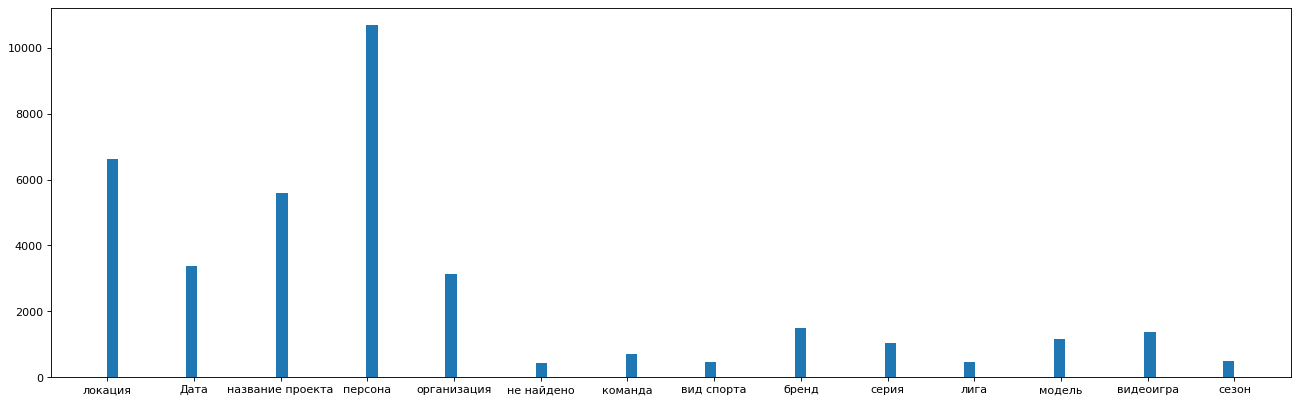

In [126]:
plt.figure(figsize=(20, 6), dpi=80)
plt.hist(variable_NER,bins=100)

#<h1>Приведение меток датасета к формату BIO</h1>

In [127]:
# Теперь из наших данных нам нужно извлечь для каждого слова (токена) его тег (label) из разметки, чтобы потом предать в модель классификации токенов


def extract_labels(sfift_item,true_item):

    # воспользуемся удобным токенайзером из библиотеки razdel,
    # она помимо разбиения на слова, сохраняет важные для нас числа - начало и конец слова в токенах

    raw_toks = list(tokenize(true_item))
    words = [tok.text for tok in raw_toks]
    # присвоим для начала каждому слову тег 'О' - тег, означающий отсутствие NER-а
    word_labels = ['O'] * len(raw_toks)
    char2word = [None] * len(true_item)
    # так как NER можем состаять из нескольких слов, то нам нужно сохранить эту инфорцию
    for i, word in enumerate(raw_toks):
        char2word[word.start:word.stop] = [i] * len(word.text)

    labels = sfift_item['entities']
    if isinstance(labels, dict):
        labels = [labels]
    if labels is not None:
        for e in labels:
            if e['label'] != 'не найдено':
                e_words = sorted({idx for idx in char2word[int(e['offset']):int(e['offset'])+int(e['length'])] if idx is not None})
                if e_words:
                    word_labels[e_words[0]] = 'B-' + e['label']
                    for idx in e_words[1:]:
                        word_labels[idx] = 'I-' + e['label']
                else:
                    continue
            else:
                continue
        return {'tokens': words, 'tags': word_labels}
    else: return {'tokens': words, 'tags': word_labels}

In [128]:
ner_data = [extract_labels(iitem1[1],iitem2) for iitem1, iitem2 in zip(df.iterrows(),df['video_info'].tolist())]

In [129]:
import pandas as pd
pd.options.display.max_colwidth = 300
dataframe_BIO=pd.DataFrame(ner_data)


In [130]:
dataframe_BIO.sample(3)

,tokens,tags
5392,"[<, НАЗВАНИЕ, :, >, Родители, в, законе, =, Фильм, 2023, (, Netflix, ), =, Русский, трейлер, в, рейтинге, <, ОПИСАНИЕ, :, >, #, kino, Простоватый, банковский, менеджер, собирается, жениться, на, любви, всей, своей, жизни, ,, но, всё, портит, тот, момент, ,, что, его, банк, грабят, неуловимые, ба...","[O, O, O, O, O, O, O, O, O, B-Дата, O, B-организация, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
2301,"[<, НАЗВАНИЕ, :, >, Замена, масла, в, двигателе, Mitsubishi, Outlander, 3, перешли, на, отечественного, производителя, <, ОПИСАНИЕ, :, >, Синтетическое, моторное, масло, ЛУКОЙЛ, Genesis, Armortech, JP, 5, W, 30, на, Яндекс, Маркет, <, LINK, >, <, LINK, >, Дзен, <, LINK, >, VK, <, LINK, >, OK, <,...","[O, O, O, O, O, O, O, O, B-бренд, B-модель, I-модель, O, O, O, O, O, O, O, O, O, O, O, B-бренд, B-модель, I-модель, I-модель, I-модель, I-модель, I-модель, O, B-бренд, I-бренд, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
2643,"[<, НАЗВАНИЕ, :, >, ⚡, Меняющие, реальность, ⚡, Фильм, 2011, года, ⚡, Русский, Трейлер, <, ОПИСАНИЕ, :, >, 📢, Русский, Трейлер, к, фильму, ►, Меняющие, реальность, 🎥, Фильм, 2011, года, 🚥, Жанр, ►, фантастика, ,, триллер, ,, мелодрама, ⚡, Возрастные, ограничения, ►, 12, +, 🎭, О, чем, ►, Случайно...","[O, O, O, O, O, B-название проекта, I-название проекта, O, O, B-Дата, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-название проекта, I-название проекта, O, O, B-Дата, I-Дата, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-персона, I-персона, I-персона, I-персона, B-персона, I-персона,..."


#Pipеline: dataset to prediction

берется датасет, состоящий только из video_info

In [131]:
test_df=dataframe['video_info'][:20]

Производится поиск NER

In [132]:
from tqdm import tqdm

def analise_dataset(test_df):

  video_infos=[]
  analise_dicts=[]
  for video_info in tqdm(test_df):
    analise_dict=full_analise_dForm(video_info)
    #удали потом clear_text, сейчас это для визуала
    video_infos.append(clear_text(video_info))
    analise_dicts.append(analise_dict)

  submission = pd.DataFrame(list(zip(video_infos,analise_dicts)),columns=[['video_info', 'entities']])
  return submission

In [133]:
submission=analise_dataset(test_df)

100%|██████████| 20/20 [00:01<00:00, 11.21it/s]


In [134]:
submission.sample(3)

,video_info,entities
2,"___________ ВЫЗОВ ДЕМОНА = Вызвал Серого Человека [Короткометражный фильм] #серыйчеловек, #короткометражныйфильм ___________ВЫЗОВ ДЕМОНА Вызвал Серого Человека [Короткометражный фильм] #серыйчеловек, #короткометражныйфильм Спасибо за просмотр. В качестве оплаты с вас лайк и подписка) Ссылки на м...","[{'label': 'организация', 'offset': 380, 'length': 6, 'segment': 'Rutube'}]"
13,"___________ Что делать женщине, если у неё два любовника, а выбрать нужно одного (2022) 1,2,3,4,5,6,7,8 серия ___________Анна — успешный адвокат, которая не стесняясь говорит своей давней подруге Ларисе, что хочет выбрать «мужа на три месяца», так как у нее сложный проект и нужен громоотвод и по...","[{'label': 'персона', 'offset': 121, 'length': 4, 'segment': 'Анна'}, {'label': 'персона', 'offset': 196, 'length': 6, 'segment': 'Ларисе'}, {'label': 'персона', 'offset': 481, 'length': 4, 'segment': 'Анна'}, {'label': 'локация', 'offset': 604, 'length': 6, 'segment': 'Англии'}, {'label': 'перс..."
3,"___________ Довоенная немецкая кирха в Калининградской области. Посетили вместе с #Заброшки39! ___________Хочешь новых эмоций, побывать в необычных местах, тогда присоединяйся к нам <AT>! Автомобильные путешествия по заброшенным старинным сооружениям. Самые необычные места Калининградской област...","[{'label': 'персона', 'offset': 12, 'length': 9, 'segment': 'Довоенная'}, {'label': 'локация', 'offset': 39, 'length': 23, 'segment': 'Калининградской области'}, {'label': 'локация', 'offset': 274, 'length': 23, 'segment': 'Калининградской области'}, {'label': 'локация', 'offset': 401, 'length':..."


Метки приводятся к формату BIO

In [135]:
prediction = [extract_labels(iitem1[1],iitem2) for iitem1, iitem2 in zip(submission.iterrows(),test_df.tolist())]
prediction_BIO=pd.DataFrame(prediction)

In [136]:
prediction_BIO.sample(3)

,tokens,tags
10,"[<, НАЗВАНИЕ, :, >, Космические, истории, ., Подготовка, космонавтов, для, работы, в, экстремальных, условиях, ., Выпуск, 09.03.2023, <, ОПИСАНИЕ, :, >, Ведущий, подкаста, ,, космонавт, Антон, Шкаплеров, ,, беседует, с, инструктором, испытателем, ЦПК, Анатолием, Забрусковым, ., Через, какие, экс...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-Дата, O, O, O, O, O, O, O, O, B-персона, I-персона, O, O, O, O, O, B-организация, B-персона, I-персона, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
9,"[<, НАЗВАНИЕ, :, >, Подготовка, к, отопительному, сезону, :, в, Хабаровске, проверили, проблемные, многоквартирные, дома, <, ОПИСАНИЕ, :, >, Отопление, в, домах, хабаровчан, включат, 8, октября, ., Паспорта, готовности, управляющие, компании, получили, ещё, до, 15, сентября, ., Но, ,, как, показ...","[O, O, O, O, O, O, O, O, O, O, B-локация, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-персона, I-персона, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-локация, O, O,..."
4,"[<, НАЗВАНИЕ, :, >, "", Спартаку, "", помогли, судьи, ?, Локомотив, засудили, ?, Стоило, ли, отменять, гол, ?, <, ОПИСАНИЕ, :, >, Спартак, #, Локомотив, #, обзор, #, обзорматча, #, всеголы, #, Локо, #, ЛокомотивМосква, #, голПруцева, #, ЛокомотивСпартакобзор, #, ЛокомотивСпартакполныйматч, #, Кубо...","[O, O, O, O, O, B-организация, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-организация, O, B-организация, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-локация, O, O, O, O, O, O, O, B-персона, O, B-организация]"


In [137]:
def get_predict(test_df):
  submission=analise_dataset(test_df)
  prediction = [extract_labels(iitem1[1],iitem2) for iitem1, iitem2 in zip(submission.iterrows(),test_df.tolist())]

  prediction_BIO=pd.DataFrame(prediction)
  #predictions=[]
  #for x in prediction:
  #  predictions.append(x)

  #prediction_BIO = pd.DataFrame(zip(test_df.tolist(),predictions))
  #prediction = pd.DataFrame([extract_labels(item) for i, item in submission.iterrows()])
  prediction_BIO=pd.DataFrame(list(zip(test_df.tolist(),prediction_BIO['tags'].tolist())),columns=['video_info','entities_prediction'])
  #prediction_BIO=pd.DataFrame(zip(test_df,prediction),columns=['video_info','entities_prediction'])
  return prediction_BIO

In [138]:
prediction=get_predict(test_df)

100%|██████████| 20/20 [00:01<00:00, 11.76it/s]


In [139]:
prediction

,video_info,entities_prediction
0,"<НАЗВАНИЕ:> Агент 117: Из Африки с любовью — Русский тизер=трейлер (2021) <ОПИСАНИЕ:>Лучший Telegram канал о кино <LINK> Сотрудничество <LINK> Дата выхода 26 августа 2021 Оригинальное название: OSS 117: Alerte rouge en Afrique noire Страна: Франция Режиссер: Николя Бедос Жанр: боевик, комедия В ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-организация, O, O, O, O, O, O, O, O, B-организация, O, O, O, B-Дата, I-Дата, I-Дата, O, O, O, O, O, O, O, O, O, O, O, O, O, B-локация, O, O, B-персона, I-персона, I-персона, O, O, O, O, O, O, O, O, B-персона, I-персона, O..."
1,"<НАЗВАНИЕ:> Коленвал Инфинити Ку икс 56= 5.6 VK56 VK56DE VK56=DE Коленный Вал Infiniti QX56= 5.6 стандартный <ОПИСАНИЕ:><LINK> kolenval infiniti iks.html Коленвал Инфинити Ку икс 56​ Коленный Вал Infiniti QX56​ Модель Двигателя: VK56, VK56DE, VK56 DE Рабочий объем двигателя: 5.6 Мощность в л.с. ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-организация, I-организация, I-организация, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
2,"<НАЗВАНИЕ:> ВЫЗОВ ДЕМОНА = Вызвал Серого Человека [Короткометражный фильм] #серыйчеловек, #короткометражныйфильм <ОПИСАНИЕ:>ВЫЗОВ ДЕМОНА Вызвал Серого Человека [Короткометражный фильм] #серыйчеловек, #короткометражныйфильм Спасибо за просмотр. В качестве оплаты с вас лайк и подписка) Ссылки на м...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-организация, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
3,"<НАЗВАНИЕ:> Довоенная немецкая кирха в Калининградской области. Посетили вместе с #Заброшки39! <ОПИСАНИЕ:>Хочешь новых эмоций, побывать в необычных местах, тогда присоединяйся к нам <AT>! Автомобильные путешествия по заброшенным старинным сооружениям. Самые необычные места Калининградской област...","[O, O, O, O, B-персона, O, O, O, B-локация, I-локация, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-локация, I-локация, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-локация..."
4,"<НАЗВАНИЕ:> ""Спартаку"" помогли судьи? Локомотив засудили? Стоило ли отменять гол? <ОПИСАНИЕ:>Спартак #Локомотив #обзор #обзорматча #всеголы #Локо #ЛокомотивМосква #голПруцева #ЛокомотивСпартакобзор #ЛокомотивСпартакполныйматч #Кубок #КубокРоссии #ЛокомотивСпартаксудья #отмененныйгол #ЛокомотивСп...","[O, O, O, O, O, B-организация, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-организация, O, B-организация, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-локация, O, O, O, O, O, O, O, B-персона, O, B-организация]"
5,<НАЗВАНИЕ:> Анекдот = В вашем борще моя курочка))) Смешные анекдоты от Таливерга ))) Юмор Смех Позитив! <ОПИСАНИЕ:>Анекдот как еврей подошел к своей соседке и предложил ей на её масле пожарить себе яичницу...Смешные анекдоты от Таливерга)))Всем приятного просмотра #Анекдоты #смешныеАнекдты #смеш...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-персона, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-персона, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
6,<НАЗВАНИЕ:> Павшим в боях за оборону своей родины = посвящается: 35=я бронебашенная батарея <ОПИСАНИЕ:>Мой личный блог о Путешествиях: <LINK> #блог #тревл #путешествия #заработок ►Поддержать канал (донат): <LINK> ►Мой канал в Яндекс Дзен: zen.yandex.ru/alexandr_rodiaev ►Инстаграм<LINK>... ►ВКонт...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-организация

#<h1>Подсчет метрик</h1>

In [140]:
import numpy as np

In [141]:
from datasets import load_dataset, load_metric
metric = load_metric("seqeval")
def calculate_matric(dataframe):

  ner_data = [extract_labels(iitem1[1],iitem2) for iitem1, iitem2 in zip(dataframe.iterrows(),dataframe['video_info'].tolist())]
  dataframe_BIO=pd.DataFrame(ner_data)
  y_true=dataframe_BIO['tags'].tolist()

  y_predict=get_predict(dataframe['video_info'])['entities_prediction'].tolist()


  arr=metric.compute(predictions=y_predict, references=y_true)

  return arr



In [142]:
mertics=calculate_matric(df)

100%|██████████| 6042/6042 [04:12<00:00, 23.94it/s]
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [143]:
mertics

{'Дата': {'precision': 0.5825545171339563,
  'recall': 0.16912873078082605,
  'f1': 0.26214953271028035,
  'number': 3317},
 'бренд': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1492},
 'вид спорта': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 467},
 'видеоигра': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1288},
 'команда': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 713},
 'лига': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 450},
 'локация': {'precision': 0.5000587751263665,
  'recall': 0.6439600363306085,
  'f1': 0.5629590418844704,
  'number': 6606},
 'модель': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1156},
 'название проекта': {'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'number': 5394},
 'организация': {'precision': 0.10604598810098087,
  'recall': 0.4210022342802426,
  'f1': 0.16941750690385976,
  'number': 3133},
 'персона': {'precision': 0.5581782637028455,
  'recall': 0.7232385777277418,
  'f1': 0.630

#<h1>playground</h1>

In [97]:
#модифицированный get_predict для удобново ввода со стороны пользователя
def get_predict_modify(text):
  data=pd.DataFrame([[text]])
  y_pred=get_predict(data[0])
  return y_pred

In [102]:
text="""Кинозал ДК приглашает на мультфильм "Потеряшки и Тайна волшебной пирамиды", 6+, 80 мин. #кинозалДКям <ОПИСАНИЕ:>Кинозал ДК Гаврилов Ямского МР приглашает с 31 марта на мультфильм "Потеряшки и Тайна волшебной пирамиды", 6+, 80 мин. Стоимость билетов 100 220 руб."""

In [103]:
get_predict_modify(text)

100%|██████████| 1/1 [00:00<00:00, 41.48it/s]


,video_info,entities_prediction
0,"Кинозал ДК приглашает на мультфильм ""Потеряшки и Тайна волшебной пирамиды"", 6+, 80 мин. #кинозалДКям <ОПИСАНИЕ:>Кинозал ДК Гаврилов Ямского МР приглашает с 31 марта на мультфильм ""Потеряшки и Тайна волшебной пирамиды"", 6+, 80 мин. Стоимость билетов 100 220 руб.","[B-организация, I-организация, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-организация, B-персона, I-персона, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"


#<h1>Дополнительно<h2>

Сравнение разных моделей для NER

In [ ]:
text="Шоу «Ярче звёзд» соберет самых талантливых вокалистов и прирожденных артистов из народа на одной сцене. Все они будут перевоплощаться в своих любимых исполнителей, а тот, кто сделает это убедительнее остальных, получит внушительный денежный приз и, конечно, всероссийскую славу и признание звёзд эстрады."

In [ ]:
import spacy

nlp = spacy.load("ru_core_news_sm")
doc = nlp(text)
for ent in doc.ents:
    print(ent.text, ent.label_)

In [ ]:
exctract_NER(text)

[]

Сравнение y_true и y_pred

In [ ]:
def contrast_entites(df):
  y_pred=analise_dataset(df['video_info'])
  #y_pred=get_predict(df['video_info'])
  y_pred['start entities']=df['entities'].tolist()
  return y_pred

In [ ]:
y_pred=contrast_entites(df.loc[2000:3000])

100%|██████████| 1001/1001 [00:46<00:00, 21.59it/s]


In [ ]:
y_pred.to_csv('./test.csv', index=False, encoding='utf-8',sep=';')

TO DO

In [ ]:
"""
 {'Дата', +
 'бренд',
 'вид спорта',+
 'видеоигра',
 'команда',
 'лига',
 'локация', +
 'модель',
 'название проекта',
 'организация', +
 'персона', +
 'сезон', +
 'серия'} +
 """

"\n {'Дата', +\n 'бренд',\n 'вид спорта',\n 'видеоигра',\n 'команда',\n 'лига',\n 'локация', +\n 'модель',\n 'название проекта',\n 'организация', +\n 'персона', +\n 'сезон', +\n 'серия'} +\n "

Функции отладки

In [ ]:
text=""
data=pd.DataFrame([[text]],columns=['video_info'])

#фунция отладки для поиска смещений при маркировки BIO
def get_predict_detect_shift(df):
  prediction_BIO=get_predict(df['video_info'])
  words_for_all_rows=[]
  for i, item in df.iterrows():
    raw_toks = list(tokenize(item['video_info']))
    words = [tok.text for tok in raw_toks]
    words_for_all_rows.append(words)

  prediction_BIO['video_info']=words_for_all_rows
  return prediction_BIO

In [ ]:
bb=get_predict_detect_shift(df.loc[:10])

100%|██████████| 11/11 [00:00<00:00, 16.16it/s]


In [ ]:
bb.to_csv('jj.csv', sep=';')

In [ ]:
b1=bb['video_info'].tolist()[0]
b2=bb['entities_prediction'].tolist()[0]

In [ ]:
for b1b,b2b in zip(b1,b2):
  print(b1b,'\t\t\t',b2b)

< 			 O
НАЗВАНИЕ 			 O
: 			 O
> 			 O
Агент 			 O
117 			 O
: 			 O
Из 			 O
Африки 			 O
с 			 O
любовью 			 O
— 			 O
Русский 			 O
тизер 			 O
= 			 O
трейлер 			 O
( 			 O
2021 			 O
) 			 O
< 			 O
ОПИСАНИЕ 			 O
: 			 O
> 			 O
Лучший 			 O
Telegram 			 B-организация
канал 			 O
о 			 O
кино 			 O
< 			 O
LINK 			 O
> 			 O
Сотрудничество 			 O
< 			 O
LINK 			 B-организация
> 			 O
Дата 			 O
выхода 			 O
26 			 B-Дата
августа 			 I-Дата
2021 			 I-Дата
Оригинальное 			 O
название 			 O
: 			 O
OSS 			 O
117 			 O
: 			 O
Alerte 			 O
rouge 			 O
en 			 O
Afrique 			 O
noire 			 O
Страна 			 O
: 			 O
Франция 			 B-локация
Режиссер 			 O
: 			 O
Николя 			 B-персона
Бедос 			 I-персона
Жанр 			 I-персона
: 			 O
боевик 			 O
, 			 O
комедия 			 O
В 			 O
главных 			 O
ролях 			 O
: 			 O
Жан 			 B-персона
Дюжарден 			 I-персона
, 			 O
Пьер 			 B-персона
Нинэ 			 I-персона
, 			 O
Мелоди 			 B-персона
Каста 			 I-персона
, 			 O
Наташа 			 B-персона
Линдинжер 			 I-персона
, 		

#тестовый датасет

In [144]:
dataframe=pd.read_csv('./ner_data_test.csv')
y_predict=get_predict(dataframe['video_info'])

100%|██████████| 1606/1606 [01:13<00:00, 21.72it/s]


In [147]:
y_predict.to_csv('test.csv')